In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import SnowballStemmer,WordNetLemmatizer

In [3]:
import datetime
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [4]:
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
pd.set_option('max_colwidth',400)

In [5]:
train_raw = pd.read_csv('./movie-review-sentiment-analysis-kernels-only/train.tsv', sep='\t')
test_raw = pd.read_csv('./movie-review-sentiment-analysis-kernels-only/test.tsv', sep='\t')

In [6]:
train_raw.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [7]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [8]:
train = train_raw
test = test_raw
train['text']=clean_review(train.Phrase.values)
test['text']=clean_review(test.Phrase.values)
y = train['Sentiment']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train.text.values,y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [10]:
vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1)
full_text = list(train['text'].values)
vectorizer.fit(full_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words=None, strip_accents='unicode', sublinear_tf=1,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=1,
        vocabulary=None)

In [11]:
X_train_tfv =  vectorizer.transform(X_train)
X_test_tfv = vectorizer.transform(X_test)
test_tfv = vectorizer.transform(test['text'].values)

In [12]:
lr = LogisticRegression(C=1.0)
lr.fit(X_train_tfv, y_train)
predictions1 = lr.predict(X_test_tfv)
print("accuracy_score",accuracy_score(y_test, predictions1))

/home/hlz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hlz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy_score 0.6438549275919518


In [13]:
# Compute confusion matrix & plot
# Code adopted from Stackoverflow, credit to @Brad Solomon
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[1.73e-01 4.81e-01 3.37e-01 9.90e-03 0.00e+00]
 [2.42e-02 3.69e-01 5.85e-01 2.13e-02 3.67e-04]
 [1.26e-03 4.59e-02 9.01e-01 5.09e-02 1.26e-03]
 [0.00e+00 1.43e-02 4.93e-01 4.64e-01 2.85e-02]
 [0.00e+00 6.51e-03 1.59e-01 5.91e-01 2.44e-01]]


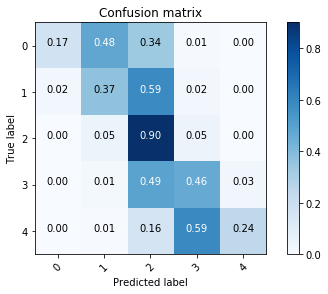

In [14]:
cm = confusion_matrix(y_test, predictions1)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, normalize=True,classes=[0, 1,2,3,4],
                      title='Confusion matrix')

In [15]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10)

In [16]:
svc = LinearSVC()
svc.fit(X_train_tfv, y_train)
predictions2 = svc.predict(X_test_tfv)
print("accuracy_score",accuracy_score(y_test, predictions2))

pred2 = svc.predict(test_tfv)

# pred_res2 = pd.DataFrame()
# pred_res2['PhraseId'] = test['PhraseId']
# pred_res2['Sentiment'] = pd.DataFrame(pred2)

# pred_res2.to_csv('pred_res2.csv',index = False)

accuracy_score 0.6638472382417019


Normalized confusion matrix
[[3.64e-01 5.05e-01 1.24e-01 5.66e-03 1.41e-03]
 [8.43e-02 5.15e-01 3.79e-01 2.05e-02 1.10e-03]
 [4.40e-03 8.33e-02 8.24e-01 8.56e-02 2.64e-03]
 [6.07e-04 2.03e-02 3.62e-01 5.33e-01 8.47e-02]
 [0.00e+00 5.43e-03 5.21e-02 5.22e-01 4.20e-01]]


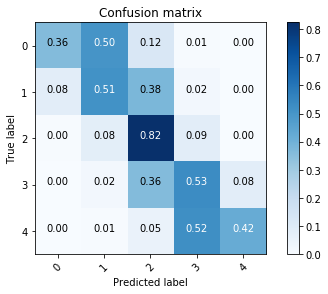

In [17]:
cm = confusion_matrix(y_test, predictions2)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, normalize=True,classes=[0, 1,2,3,4],
                      title='Confusion matrix')

In [28]:
# Set the parameters by cross-validation
tuned_parameters = {'penalty': ['l1', 'l2'], 'tol': [1e-3, 1e-4, 1e-5],'C': [1, 10, 100]}

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(LinearSVC(dual = False), tuned_parameters, cv=5, n_jobs = -1)
clf.fit(X_train_tfv, y_train)

In [24]:
# Get the best params for SVC
clf.best_params_

{'C': 1, 'penalty': 'l1'}

In [ ]:
classification_report(y_true, y_pred))

In [47]:
cross_val_score(svc, X_test_tfv, y_test, cv=k_fold, n_jobs=-1)

array([0.56, 0.57, 0.57, 0.57, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57])

## LSTM

In [28]:
import tensorflow as tf
from keras import backend

In [29]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [40]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import  GlobalMaxPool1D, SpatialDropout1D
from keras.layers import Bidirectional
from keras.models import Model
from keras import optimizers

In [27]:
tf.set_random_seed(1)
np.random.seed(1)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
backend.set_session(tf.Session(graph=tf.get_default_graph(), config=session_conf))

In [33]:
NUM_FOLDS = 5
train_raw["fold_id"] = train_raw["SentenceId"].apply(lambda x: x%NUM_FOLDS)

In [34]:
vocab_size = 20000  # based on words in the entire corpus
max_len = 60        # based on word count in phrases

all_corpus   = list(train_raw['Phrase'].values) + list(test_raw['Phrase'].values)
train_phrases  = list(train_raw['Phrase'].values) 
test_phrases   = list(test_raw['Phrase'].values)
X_train_target_binary = pd.get_dummies(train_raw['Sentiment'])

In [35]:
#Vocabulary-Indexing of thetrain and test phrases, make sure "filters" parm doesn't clean out punctuations

tokenizer = Tokenizer(num_words=vocab_size, lower=True, filters='\n\t')
tokenizer.fit_on_texts(all_corpus)
encoded_train_phrases = tokenizer.texts_to_sequences(train_phrases)
encoded_test_phrases = tokenizer.texts_to_sequences(test_phrases)

In [36]:
#Watch for a POST padding, as opposed to the default PRE padding

X_train_words = sequence.pad_sequences(encoded_train_phrases, maxlen=max_len,  padding='post')
X_test_words = sequence.pad_sequences(encoded_test_phrases, maxlen=max_len,  padding='post')
print (X_train_words.shape)
print (X_test_words.shape)
print (X_train_target_binary.shape)

print ('Done Tokenizing and indexing phrases based on the vocabulary learned from the entire Train and Test corpus')

(156060, 60)
(66292, 60)
(156060, 5)
Done Tokenizing and indexing phrases based on the vocabulary learned from the entire Train and Test corpus


In [37]:
word_index = tokenizer.word_index
embeddings_index = {}
embedding_size = 300

In [38]:
with open('./fasttext-crawl-300d-2m/crawl-300d-2M.vec', 'r') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [39]:
num_words = min(vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [41]:
early_stop = EarlyStopping(monitor = "val_loss", mode="min", patience = 3, verbose=1)
nb_epoch = 15

In [42]:
# Embedding layer for text inputs
input_words = Input((max_len, ))
x_words = Embedding(num_words, embedding_size,weights=[embedding_matrix],trainable=False)(input_words)
x_words = SpatialDropout1D(0.3)(x_words)
x_words = Bidirectional(CuDNNLSTM(50, return_sequences=True))(x_words)
x_words = Dropout(0.2)(x_words)
x_words = Conv1D(128, 1, strides = 1,  padding='causal', activation='relu', )(x_words)
x_words = Conv1D(256, 3, strides = 1,  padding='causal', activation='relu', )(x_words)
x_words = Conv1D(512, 5, strides = 1,   padding='causal', activation='relu', )(x_words)
x_words = GlobalMaxPool1D()(x_words)
x_words = Dropout(0.2)(x_words)

x = Dense(50, activation="relu")(x_words)
x = Dropout(0.2)(x)
predictions = Dense(5, activation="softmax")(x)

test_preds = np.zeros((test_raw.shape[0], 5))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
for i in range(NUM_FOLDS):
    print("FOLD", i+1)
    train, val = X_train_words[train_raw["fold_id"] != i], X_train_target_binary[train_raw["fold_id"] != i]
    
    print("Building the model...")
    model = Model(inputs=[input_words], outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["acc"])
    
    print("Training the model...")
    history = model.fit([train], 
                        val, 
                        epochs=nb_epoch, 
                        verbose=1, 
                        batch_size = 1024, 
                        callbacks=[early_stop], 
                        validation_split = 0.2, 
                        shuffle=True)
    print("Predicting...")
    test_preds += model.predict([X_test_words], batch_size=1024, verbose = 0)

FOLD 1
Building the model...
Training the model...
Train on 100184 samples, validate on 25046 samples
Epoch 1/15


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' used by node bidirectional_1/CudnnRNN (defined at /home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/cudnn_recurrent.py:517) with these attrs: [seed=1, dropout=0, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node bidirectional_1/CudnnRNN (defined at /home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/cudnn_recurrent.py:517) ]]

Caused by op 'bidirectional_1/CudnnRNN', defined at:
  File "/home/hlz/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hlz/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/hlz/anaconda3/lib/python3.7/asyncio/base_events.py", line 528, in run_forever
    self._run_once()
  File "/home/hlz/anaconda3/lib/python3.7/asyncio/base_events.py", line 1764, in _run_once
    handle._run()
  File "/home/hlz/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-b59f34317ca8>", line 5, in <module>
    x_words = Bidirectional(CuDNNLSTM(50, return_sequences=True))(x_words)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/wrappers.py", line 427, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/wrappers.py", line 522, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/cudnn_recurrent.py", line 517, in _process_batch
    is_training=True)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1636, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1527, in __call__
    seed=self._seed)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1014, in _cudnn_rnn
    outputs, output_h, output_c, _ = gen_cudnn_rnn_ops.cudnn_rnn(**args)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_cudnn_rnn_ops.py", line 142, in cudnn_rnn
    seed2=seed2, is_training=is_training, name=name)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/hlz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' used by node bidirectional_1/CudnnRNN (defined at /home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/cudnn_recurrent.py:517) with these attrs: [seed=1, dropout=0, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node bidirectional_1/CudnnRNN (defined at /home/hlz/anaconda3/lib/python3.7/site-packages/keras/layers/cudnn_recurrent.py:517) ]]


In [ ]:
print("Make the submission ready...")
submission = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv')
submission.Sentiment = np.round(np.argmax(test_preds, axis=1)).astype(int)
submission.to_csv('submission.csv',index=False)